In [1]:
import hpfrec

#### We train the model on 80% data. Remaining 20% we use for testing.

In [2]:
"""Fitting the model on training data, instead of validation set."""
recommender = hpfrec.HPF(k=40, reindex=False, stop_crit='train-llk', verbose=True, stop_thr=0.000001, maxiter=3000, random_seed=123,
                        save_folder='~/Documents/RedHat')

In [4]:
import pickle

In [5]:
with open('training-data.pkl', 'rb') as f:
    train_df = pickle.load(f)

In [7]:
with open('test-data.pkl', 'rb') as f:
    test_df = pickle.load(f)

#### We fit the model on training data

In [6]:
recommender.fit(train_df)

**********************************
Hierarchical Poisson Factorization
**********************************

Number of users: 69134
Number of items: 19113
Latent factors to use: 40

Initializing parameters...
Allocating Phi matrix...
Initializing optimization procedure...
Iteration 10 | train llk: -2680502 | train rmse: 0.8978
Iteration 20 | train llk: -2500041 | train rmse: 0.8705
Iteration 30 | train llk: -2471753 | train rmse: 0.8666
Iteration 40 | train llk: -2462954 | train rmse: 0.8652
Iteration 50 | train llk: -2452805 | train rmse: 0.8624
Iteration 60 | train llk: -2447563 | train rmse: 0.8609
Iteration 70 | train llk: -2445322 | train rmse: 0.8604
Iteration 80 | train llk: -2444132 | train rmse: 0.8602
Iteration 90 | train llk: -2443542 | train rmse: 0.8600
Iteration 100 | train llk: -2442509 | train rmse: 0.8598
Iteration 110 | train llk: -2441767 | train rmse: 0.8596
Iteration 120 | train llk: -2441155 | train rmse: 0.8595
Iteration 130 | train llk: -2440719 | train rmse: 0.859

In [9]:
import pandas as pd
import numpy as np

#### Calculate recall for the trained model on test data

In [14]:
def recall_at_m(m):
    recall = []
    for i in range(69134):
        x = np.array(test_df.loc[test_df.UserId.isin([i])].ItemId)
        l = len(x)
        recommendations = recommender.topN(user=i, n=m, exclude_seen=True)
        intersection_length = len(np.intersect1d(x, recommendations))
        try:
            recall.append({"recall": intersection_length/l, "length": l, "user": i})
        except ZeroDivisionError as e:
            pass
    
    recall_df = pd.DataFrame(recall, index=None)
    return recall_df['recall'].mean()

In [15]:
recall_at_m(50)

0.5514439046072342

In [16]:
recall_at_m(100)

0.6373126166890021

In [17]:
recall_at_m(200)

0.7241040874463005

In [18]:
recall_at_m(300)

0.7678137919769555

In [7]:
import pickle

In [9]:
"""Save the model"""
recommender.step_size = None
with open('HPF_model.pkl', 'wb') as f:
    pickle.dump(recommender, f)

In [8]:
with open('HPF_model.pkl', 'rb') as f:
    recommender = pickle.load(f)

#### We will do some common sense checks here to see if we trained the model correctly. To do that, predictions should:

1. Be higher for this non-zero hold-out sample than for random items.
2. Produce a good discrimination between random items and those in the hold-out sample (very related to the first point).
3. Be correlated with the playcounts in the hold-out sample.
4. Follow an exponential distribution rather than a normal or some other symmetric distribution.

In [10]:
import numpy as np

In [11]:
test_df['Predicted'] = recommender.predict(user=test_df.UserId, item=test_df.ItemId)
test_df['RandomItem'] = np.random.choice(train_df.ItemId, size=test_df.shape[0])
test_df['PredictedRandom'] = recommender.predict(user=test_df.UserId, item=test_df.RandomItem)
print("Average prediction for combinations in test set: ", test_df.Predicted.mean())
print("Average prediction for random combinations: ", test_df.PredictedRandom.mean())

Average prediction for combinations in test set:  0.1635301113128662
Average prediction for random combinations:  0.07973380386829376


In [12]:
from sklearn.metrics import roc_auc_score

was_played = np.r_[np.ones(test_df.shape[0]), np.zeros(test_df.shape[0])]
score_model = np.r_[test_df.Predicted.values, test_df.PredictedRandom.values]
roc_auc_score(was_played, score_model)

0.6980859520906082

In [14]:
# This is nan, because predict is bound to provide NaN values
np.corrcoef(test_df.Count, test_df.Predicted)[0,1]

/Users/aagamshah/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/aagamshah/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


nan

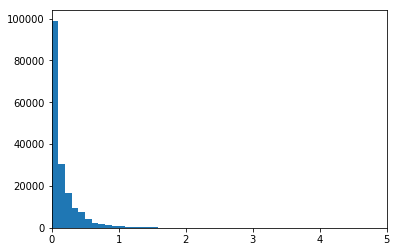

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

_ = plt.hist(test_df.Predicted, bins=80)
plt.xlim(0,5)
plt.show()